In [2]:
# import the libraries
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# read the raw CSV files (BTC dominance + political events)
btc = pd.read_csv("BTC_D_dataset.csv")


events = pd.read_csv("political_events_2020_2025.csv")

# clean BTC dominance data
# convert time column to real dates and keep only date + close value
btc["date"] = pd.to_datetime(btc["time"], dayfirst=True)


btc["btc_dominance"] = btc["close"]


btc = btc[["date", "btc_dominance"]]


btc = btc.sort_values("date")

btc.head()


/tmp/ipython-input-16333952.py:14: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  btc["date"] = pd.to_datetime(btc["time"], dayfirst=True)


,date,btc_dominance
0,2023-05-26,47.809404
1,2023-05-27,47.888934
2,2023-05-28,48.327372
3,2023-05-29,48.175823
4,2023-05-30,47.992350


In [3]:
# clean political events data (make date column datetime)
events["date"] = pd.to_datetime(events["date"], dayfirst=True, errors="raise")
events.head()


,date,event_name,category,severity,region
0,2020-01-03,USA-Iran conflict escalation after Soleimani s...,war,high,Middle East
1,2020-03-11,WHO declares COVID-19 global pandemic,crisis,high,Global
2,2020-11-03,US Presidential Election,election,high,USA
3,2021-01-06,US Capitol Riot political crisis,crisis,medium,USA
4,2021-05-19,China intensifies national crypto crackdown,regulation,high,China


In [4]:

#merge BTC dominance with political events on the date
merged = pd.merge(
    btc,
    events,
    on="date",
    how="left"
)

merged["event_flag"] = merged["event_name"].notna().astype(int)
merged.head()


,date,btc_dominance,event_name,category,severity,region,event_flag
0,2023-05-26,47.809404,NaN,NaN,NaN,NaN,0
1,2023-05-27,47.888934,NaN,NaN,NaN,NaN,0
2,2023-05-28,48.327372,NaN,NaN,NaN,NaN,0
3,2023-05-29,48.175823,NaN,NaN,NaN,NaN,0
4,2023-05-30,47.992350,NaN,NaN,NaN,NaN,0


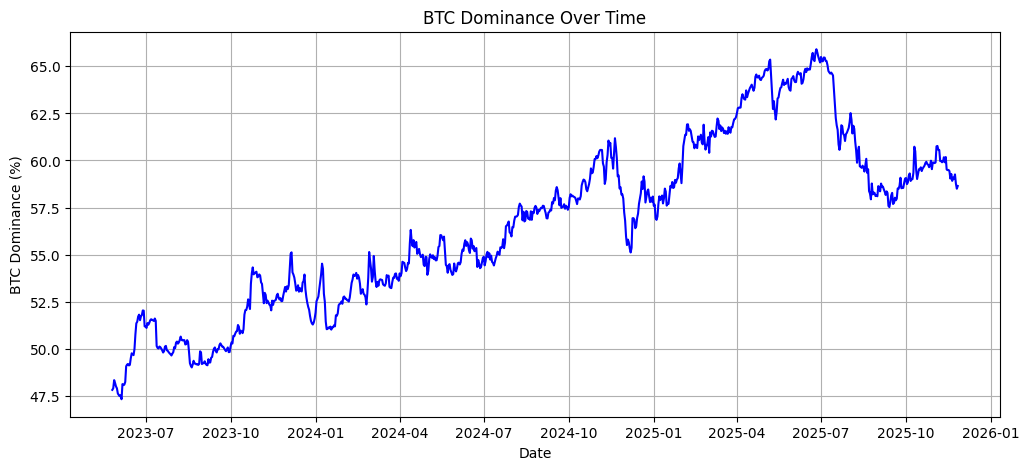

In [5]:

#plot BTC dominance over time
plt.figure(figsize=(12,5))
plt.plot(merged["date"], merged["btc_dominance"], color="blue")
plt.title("BTC Dominance Over Time")
plt.xlabel("Date")
plt.ylabel("BTC Dominance (%)")
plt.grid(True)
plt.show()


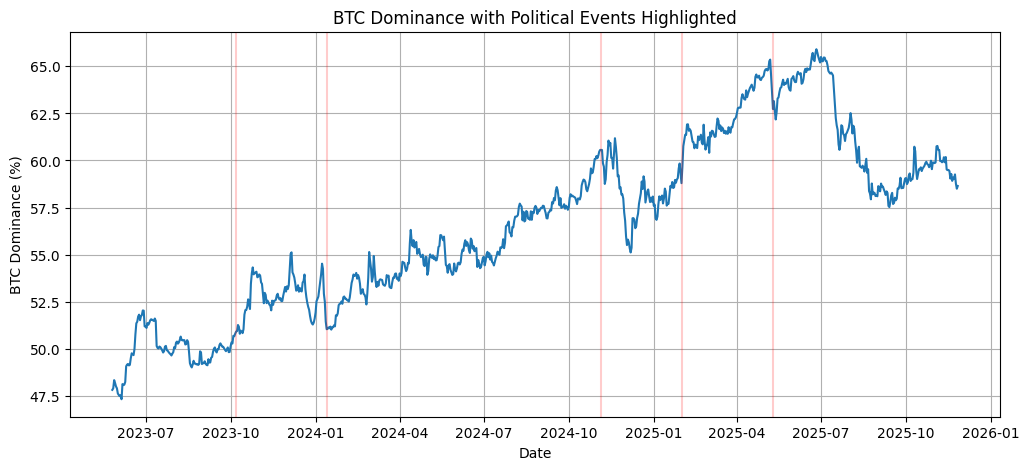

In [6]:

#plot BTC dominance and mark political event days with vertical lines
plt.figure(figsize=(12,5))
plt.plot(merged["date"], merged["btc_dominance"], label="BTC Dominance")


for d in merged.loc[merged["event_flag"]==1, "date"]:
    plt.axvline(d, color="red", alpha=0.2)

plt.title("BTC Dominance with Political Events Highlighted")
plt.xlabel("Date")
plt.ylabel("BTC Dominance (%)")
plt.grid(True)
plt.show()


In [7]:

# compare BTC dominance on event days vs normal days

event_days = merged[merged["event_flag"]==1]["btc_dominance"]
normal_days = merged[merged["event_flag"]==0]["btc_dominance"]

print("Average BTC dominance on event days:", event_days.mean())
print("Average BTC dominance on normal days:", normal_days.mean())

# simple t-test between event and non-event days
t_stat, p_val = ttest_ind(event_days, normal_days, equal_var=False)

print("t-statistic:", t_stat)
print("p-value:", p_val)


Average BTC dominance on event days: 56.98212081467344
Average BTC dominance on normal days: 56.62774437230378
t-statistic: 0.14123184080081558
p-value: 0.8944672821859021


In [8]:
merged.to_csv("btc_dominance_with_events.csv", index=False)


Machine Learning (Baseline Model)

For the machine learning part of this project, I wanted to test a simple question:

Do major political event days relate to short-term changes in Bitcoin dominance?

I am not trying to predict the crypto market, since Bitcoin dominance is influenced by many different factors. Instead, I use a simple and interpretable baseline model to check whether days with political events behave differently from normal days.

Feature (X):
event_flag → 1 if a major political event occurred on that date, 0 otherwise.

Target (y):
btc_change → daily change in Bitcoin dominance, calculated as the difference between today’s and yesterday’s dominance values.

I chose Linear Regression because it is simple and easy to interpret. The regression coefficient shows the average difference in Bitcoin dominance change on event days compared to non-event days.

One practical detail is that calculating daily change using diff() creates a missing value in the first row, so that row is removed before training the model.

In [9]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Load the merged dataset
df = pd.read_csv("btc_dominance_with_events.csv")

# Clean column names (just in case there are spaces)
df.columns = df.columns.str.strip()

# Convert date and sort
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

#  Input (X): event_flag (0 = no event, 1 = event)
#  Output (y): daily change in btc_dominance
df["btc_change"] = df["btc_dominance"].diff()

# Drop first row because diff() creates a missing value
df = df.dropna(subset=["btc_change"]).copy()

X = df[["event_flag"]]
y = df["btc_change"]

# Simple sanity check (helps me understand the data)
print("Total rows used:", len(df))
print("Event days:", int(df["event_flag"].sum()))
print("Non-event days:", int((df["event_flag"] == 0).sum()))

from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate on test data
r2 = model.score(X_test, y_test)

print("Test R² score:", r2)
print("Coefficient (event effect):", model.coef_[0])
print("Intercept:", model.intercept_)



Total rows used: 915
Event days: 5
Non-event days: 910
Test R² score: -0.000641255407883401
Coefficient (event effect): 0.010712477394999592
Intercept: 0.012418074199709974


ML Interpretation:
The regression coefficient is slightly positive, meaning that on days with major political events, Bitcoin dominance tends to increase by a very small amount on average. However, the test R² score is close to zero, indicating that political events alone do not explain most of the variation in daily BTC dominance changes.

In addition, the number of event days is extremely small compared to non-event days, which limits the strength and reliability of the model. Overall, this suggests that while political events may have some influence, Bitcoin dominance is largely driven by many other market factors.

## Exploratory Data Analysis (EDA)


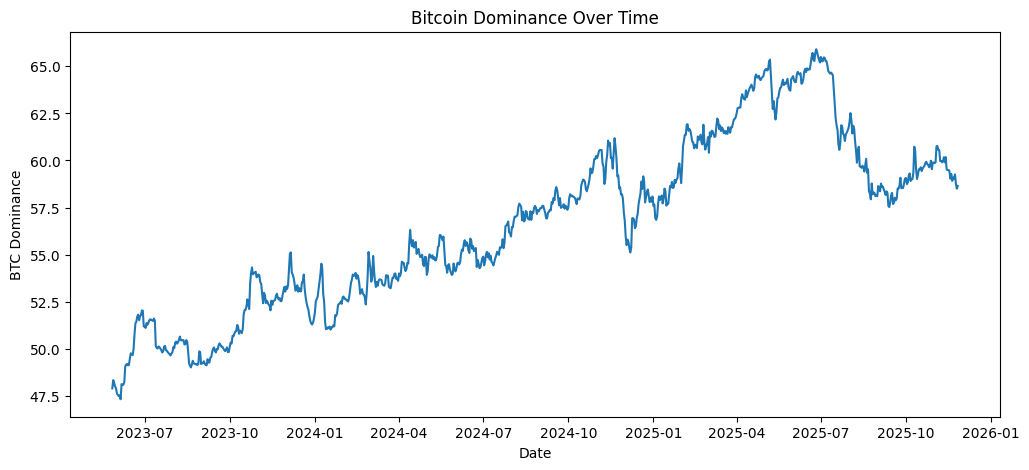

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df["date"], df["btc_dominance"])
plt.xlabel("Date")
plt.ylabel("BTC Dominance")
plt.title("Bitcoin Dominance Over Time")
plt.show()


**Figure 1:** This plot shows how Bitcoin dominance changes over time. I use it to get a general sense of the overall trend and to see whether there are periods where Bitcoin becomes more or less dominant compared to the rest of the crypto market.


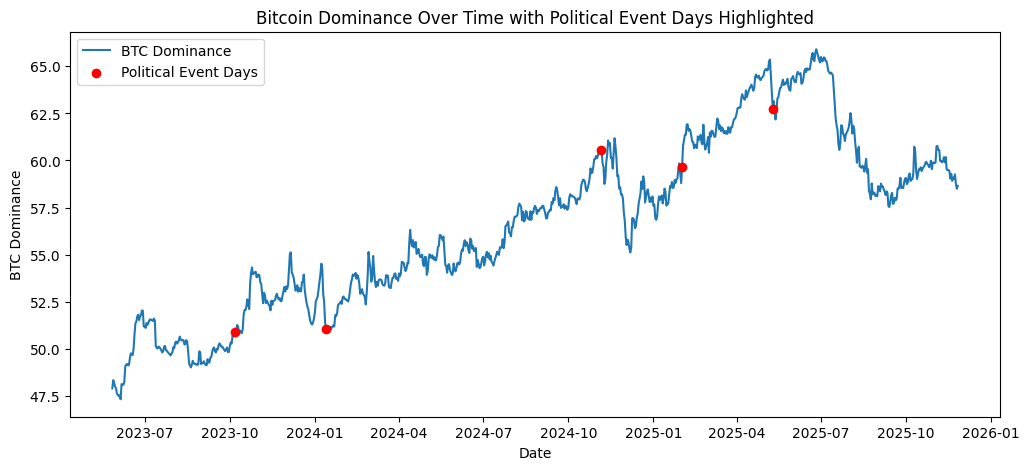

In [11]:
plt.figure(figsize=(12, 5))

# Plot BTC dominance over time
plt.plot(df["date"], df["btc_dominance"], label="BTC Dominance")

# Highlight event days
event_days = df[df["event_flag"] == 1]
plt.scatter(
    event_days["date"],
    event_days["btc_dominance"],
    color="red",
    label="Political Event Days",
    zorder=3
)

plt.xlabel("Date")
plt.ylabel("BTC Dominance")
plt.title("Bitcoin Dominance Over Time with Political Event Days Highlighted")
plt.legend()
plt.show()


**Figure 2:** This plot shows Bitcoin dominance over time with major political event days highlighted in red. I added this visualization to visually check whether event days tend to coincide with noticeable changes or unusual movements in Bitcoin dominance.


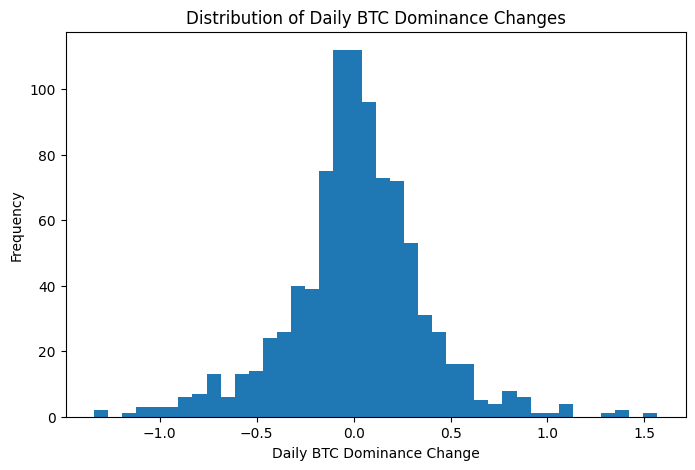

In [12]:
plt.figure(figsize=(8, 5))
plt.hist(df["btc_change"], bins=40)
plt.xlabel("Daily BTC Dominance Change")
plt.ylabel("Frequency")
plt.title("Distribution of Daily BTC Dominance Changes")
plt.show()


**Figure 3:** This histogram shows the distribution of daily changes in Bitcoin dominance. Most changes are small and centered around zero, which highlights how noisy short-term movements are and helps explain why it is difficult for simple models to capture strong patterns.


/tmp/ipython-input-285761288.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=["Non-Event Days", "Event Days"])


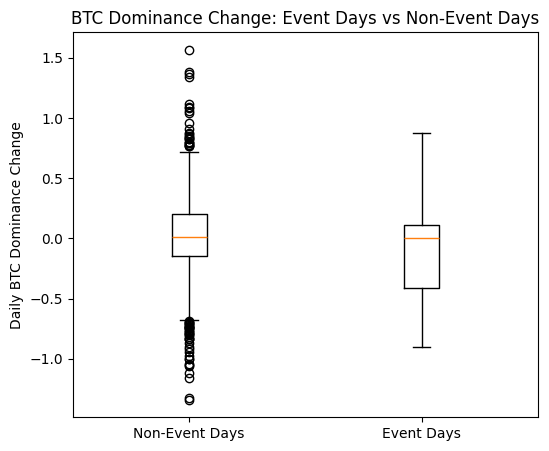

In [13]:
plt.figure(figsize=(6, 5))

data_to_plot = [
    df[df["event_flag"] == 0]["btc_change"],
    df[df["event_flag"] == 1]["btc_change"]
]

plt.boxplot(data_to_plot, labels=["Non-Event Days", "Event Days"])
plt.ylabel("Daily BTC Dominance Change")
plt.title("BTC Dominance Change: Event Days vs Non-Event Days")
plt.show()


**Figure 4:** This boxplot compares daily Bitcoin dominance changes on event days versus non-event days. While there is some variation between the two groups, the overlap between the distributions suggests that political events alone do not lead to consistently large short-term changes in Bitcoin dominance.


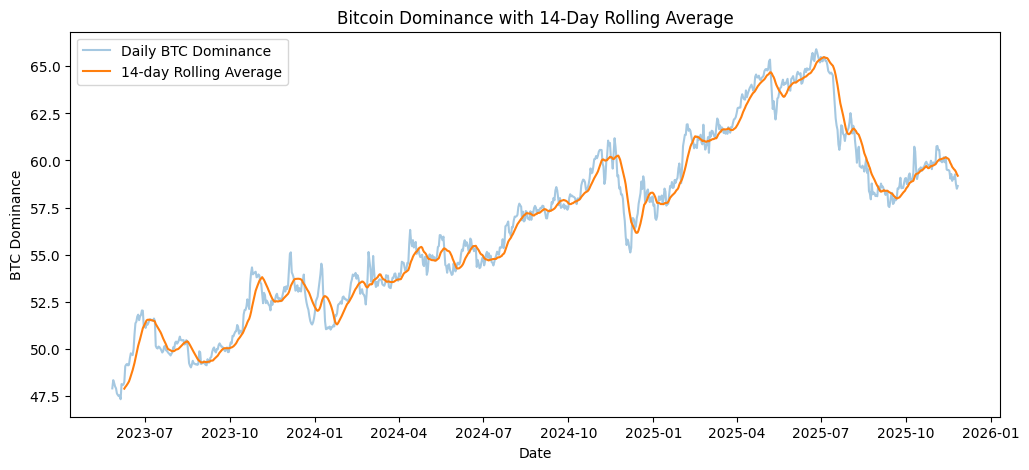

In [14]:
# Calculate 14-day rolling average
df["btc_dominance_rolling"] = df["btc_dominance"].rolling(window=14).mean()

plt.figure(figsize=(12, 5))
plt.plot(df["date"], df["btc_dominance"], alpha=0.4, label="Daily BTC Dominance")
plt.plot(df["date"], df["btc_dominance_rolling"], label="14-day Rolling Average")
plt.xlabel("Date")
plt.ylabel("BTC Dominance")
plt.title("Bitcoin Dominance with 14-Day Rolling Average")
plt.legend()
plt.show()


**Figure 5:** This plot shows Bitcoin dominance together with a 14-day rolling average. The rolling average smooths out daily fluctuations and makes it easier to observe short-term trends, highlighting that single-day movements can be noisy and misleading.


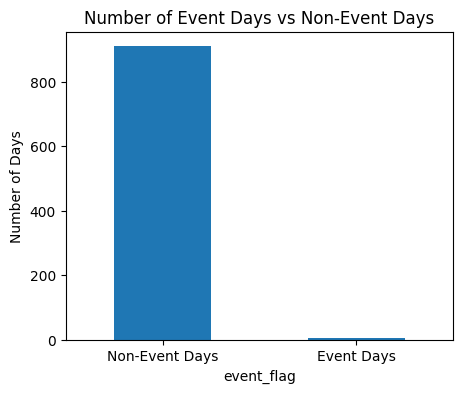

In [15]:
event_counts = df["event_flag"].value_counts()

plt.figure(figsize=(5, 4))
event_counts.plot(kind="bar")
plt.xticks([0, 1], ["Non-Event Days", "Event Days"], rotation=0)
plt.ylabel("Number of Days")
plt.title("Number of Event Days vs Non-Event Days")
plt.show()


**Figure 6:** This bar chart shows the number of event days compared to non-event days in the dataset. The strong imbalance highlights that political events are relatively rare, which limits the statistical power of the analysis and helps explain why the model does not show strong predictive performance.
